# Fifa 18 Value Prediction
## Data Exploration and Cleaning

In [36]:
# Imports
import os
import pandas as pd
import re
import seaborn as sns
import numpy as np
from IPython.display import display, HTML, Markdown as md
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Config
%matplotlib notebook
pd.options.display.max_columns = None

### Load the data
Loads *.csv* file into *pandas DataFrame*

In [37]:
df = pd.read_csv("data/raw/CompleteDataset.csv")

c:\users\matias\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Explore the data
First look at the data. 

In [38]:
# Takes a look at the DataFrame's shape.
display(md("**Initial** DataFrame's shape: {0}".format(df.shape)))

# Column's types and number of non-null values
display(md(df.info()))

**Initial** DataFrame's shape: (17981, 75)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17981 entries, 0 to 17980
Data columns (total 75 columns):
Unnamed: 0             17981 non-null int64
Name                   17981 non-null object
Age                    17981 non-null int64
Photo                  17981 non-null object
Nationality            17981 non-null object
Flag                   17981 non-null object
Overall                17981 non-null int64
Potential              17981 non-null int64
Club                   17733 non-null object
Club Logo              17981 non-null object
Value                  17981 non-null object
Wage                   17981 non-null object
Special                17981 non-null int64
Acceleration           17981 non-null object
Aggression             17981 non-null object
Agility                17981 non-null object
Balance                17981 non-null object
Ball control           17981 non-null object
Composure              17981 non-null object
Crossing               17981 non-null obj

<IPython.core.display.Markdown object>

### Data types
We can see that there are many columns parsed as *object* that must be *int64* or *float64*. Let's look why this happens.

In [39]:
# Let´s look why 'Wage' and 'Value' are not parsed as numbers
display(df.loc[:, ["Wage", "Value"]].sample(5))

# Many skill attributes (e.g. 'Acceleration') are also not parsed as numbers
for index, acceleration in df["Acceleration"].iteritems():
    try:
        val = int(acceleration)
    except ValueError:
        display("{0} is not a number!".format(acceleration))
        break

,Wage,Value
16039,€1K,€190K
6885,€9K,€350K
15069,€1K,€300K
5749,€24K,€1.5M
12075,€1K,€625K


'70+9 is not a number!'

In [40]:
def get_number(s):
    """ Returns 's' as a number in € """
    scale = 1
    if re.search("K", s) is not None: # Thousand symbol
        scale = 1000
    elif re.search("M", s) is not None: # Million symbol
        scale = 1000000
    
    return float(re.search("[0-9]+\.?[0-9]*", s).group(0)) * scale

df["Wage"] = df["Wage"].map(get_number).astype("float64")
df["Value"] = df["Value"].map(get_number).astype("float64")

# Many columns are not parsed as 'int64' because of a '+' or '-' sign indicating the change the attribute has seen from the 
# last iteration.
for col in df.select_dtypes(include='object').columns:
    if df[col].str.contains("[0-9]+[\+|-][0-9]+", regex=True).any():
        df.loc[:, col] = df[col].str.replace("(?![0-9]+)[\+|-][0-9]+", "")
        
        df[col] = df[col].astype('float')
        
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17981 entries, 0 to 17980
Data columns (total 75 columns):
Unnamed: 0             17981 non-null int64
Name                   17981 non-null object
Age                    17981 non-null int64
Photo                  17981 non-null object
Nationality            17981 non-null object
Flag                   17981 non-null object
Overall                17981 non-null int64
Potential              17981 non-null int64
Club                   17733 non-null object
Club Logo              17981 non-null object
Value                  17981 non-null float64
Wage                   17981 non-null float64
Special                17981 non-null int64
Acceleration           17981 non-null float64
Aggression             17981 non-null float64
Agility                17981 non-null float64
Balance                17981 non-null float64
Ball control           17981 non-null float64
Composure              17981 non-null float64
Crossing               17981 non-

None

### Missing values
There are many features with 15952 non-null values. That's because **goalkeepers** don't have the positional features.

In [41]:
# Checks goalkeepers values
df_gk = df.loc[df["Preferred Positions"] == "GK ", :]

display("Goalkeepers subset's shape: {0}".format(df_gk.shape))

display(df_gk.info())

"Goalkeepers subset's shape: (2029, 75)"

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2029 entries, 4 to 17977
Data columns (total 75 columns):
Unnamed: 0             2029 non-null int64
Name                   2029 non-null object
Age                    2029 non-null int64
Photo                  2029 non-null object
Nationality            2029 non-null object
Flag                   2029 non-null object
Overall                2029 non-null int64
Potential              2029 non-null int64
Club                   1987 non-null object
Club Logo              2029 non-null object
Value                  2029 non-null float64
Wage                   2029 non-null float64
Special                2029 non-null int64
Acceleration           2029 non-null float64
Aggression             2029 non-null float64
Agility                2029 non-null float64
Balance                2029 non-null float64
Ball control           2029 non-null float64
Composure              2029 non-null float64
Crossing               2029 non-null float64
Curve   

None

In [42]:
# Fill 'Free kick accuracy' and 'Penalties' null values with the goalkeepers mean
free_kick_accuracy_gk_mean = int(df_gk["Free kick accuracy"].mean())
penalties_gk_mean = int(df_gk["Penalties"].mean())

df["Free kick accuracy"].fillna(free_kick_accuracy_gk_mean, inplace=True)
df["Free kick accuracy"].astype("float64")
df["Penalties"].fillna(penalties_gk_mean, inplace=True)
df["Penalties"].astype("float64")

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17981 entries, 0 to 17980
Data columns (total 75 columns):
Unnamed: 0             17981 non-null int64
Name                   17981 non-null object
Age                    17981 non-null int64
Photo                  17981 non-null object
Nationality            17981 non-null object
Flag                   17981 non-null object
Overall                17981 non-null int64
Potential              17981 non-null int64
Club                   17733 non-null object
Club Logo              17981 non-null object
Value                  17981 non-null float64
Wage                   17981 non-null float64
Special                17981 non-null int64
Acceleration           17981 non-null float64
Aggression             17981 non-null float64
Agility                17981 non-null float64
Balance                17981 non-null float64
Ball control           17981 non-null float64
Composure              17981 non-null float64
Crossing               17981 non-

None

In [43]:
# Lionel Messi and Gianluigi Buffon example
lionel_messi_filter = df["Name"].str.contains("L. Messi") | df["Name"].str.contains("G. Buffon")
display(df.loc[lionel_messi_filter, :])

,Unnamed: 0,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Acceleration,Aggression,Agility,Balance,Ball control,Composure,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,GK diving,GK handling,GK kicking,GK positioning,GK reflexes,Heading accuracy,Interceptions,Jumping,Long passing,Long shots,Marking,Penalties,Positioning,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys,CAM,CB,CDM,CF,CM,ID,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,Preferred Positions,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
1,1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,105000000.0,565000.0,2154,92.0,48.0,90.0,95.0,95.0,96.0,77.0,89.0,97.0,95.0,90.0,6.0,11.0,15.0,14.0,8.0,71.0,22.0,68.0,87.0,88.0,13.0,74.0,93.0,95.0,88.0,85.0,26.0,87.0,73.0,28.0,59.0,90.0,85.0,92.0,45.0,59.0,92.0,84.0,158023,92.0,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,RW,92.0,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
18,18,G. Buffon,39,https://cdn.sofifa.org/48/18/players/1179.png,Italy,https://cdn.sofifa.org/flags/27.png,89,89,Juventus,https://cdn.sofifa.org/24/18/teams/45.png,4500000.0,110000.0,1335,49.0,38.0,55.0,49.0,28.0,70.0,13.0,20.0,26.0,15.0,13.0,89.0,88.0,74.0,90.0,84.0,13.0,28.0,75.0,35.0,13.0,10.0,22.0,12.0,80.0,37.0,39.0,11.0,43.0,39.0,11.0,69.0,50.0,17.0,NaN,NaN,NaN,NaN,NaN,1179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Feature selection

In [44]:
# We are not interested in the images features, Club and Nationality
drop_columns = ["Unnamed: 0", "Photo", "Flag", "Club Logo", "Club", "Nationality"]
df.drop(labels=drop_columns, axis="columns", inplace=True)

display(md("Unused columns: {0}".format(drop_columns)))
display(md("**Actual** DataFrame's shape: {0}".format(df.shape)))

Unused columns: ['Unnamed: 0', 'Photo', 'Flag', 'Club Logo', 'Club', 'Nationality']

**Actual** DataFrame's shape: (17981, 69)

### Categorical features
*Preferred Positions* is categorical.

Most Machine Learning algorithms prefer to work with numbers, so let's convert this text label to numbers.

In [45]:
display(md("*Preferred Positions* has {0} unique values".format(len(df["Preferred Positions"].unique()))))

# So, let's save only one preferred positions per player
df["Preferred Position"] = df["Preferred Positions"].apply(lambda x: re.search("(\w+)\s", x).group(1))

df = pd.get_dummies(df, columns=["Preferred Position"])
df.drop(labels=["Preferred Positions"], axis="columns", inplace=True)

*Preferred Positions* has 802 unique values

### Correlations
Let's analyze the correlations between the features.

<IPython.core.display.Javascript object>


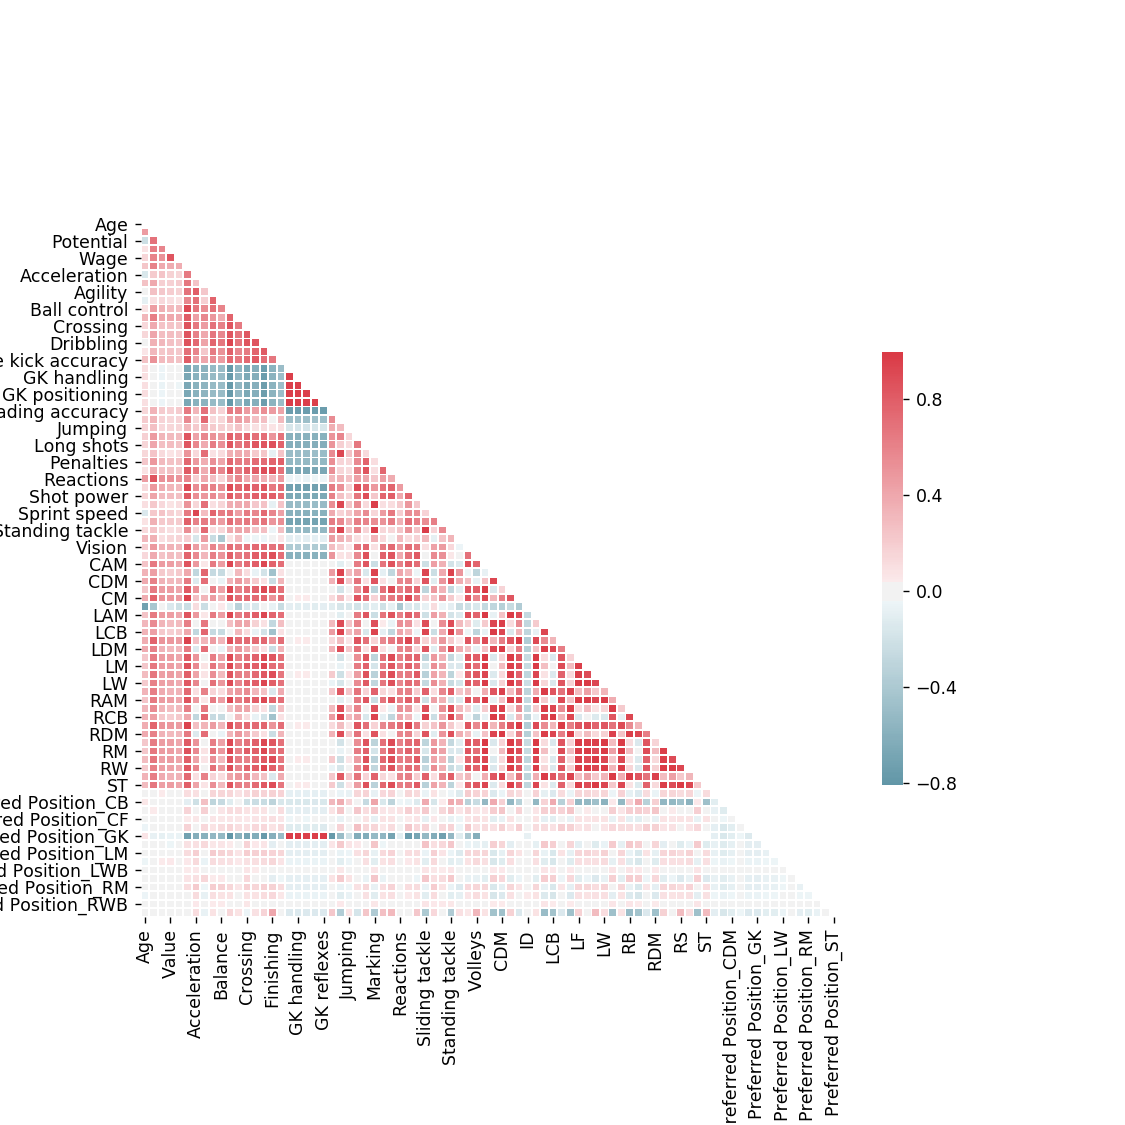

In [46]:
# Correlation matrix
corr_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [47]:
# Let's take a look at the correlations with our target variable
corr_value = corr_matrix["Value"].sort_values(ascending=False)

display(md("As expected, *Wage, Overall and Potential* are strongly correlated with *Value*"))
display(corr_value[0:5])
display(corr_value[-5:])

As expected, *Wage, Overall and Potential* are strongly correlated with *Value*

Value        1.000000
Wage         0.850510
Overall      0.626001
Potential    0.588074
Reactions    0.531255
Name: Value, dtype: float64

GK kicking              -0.034230
Preferred Position_RB   -0.034807
Preferred Position_LB   -0.039978
Preferred Position_GK   -0.054119
ID                      -0.140623
Name: Value, dtype: float64

<IPython.core.display.Javascript object>


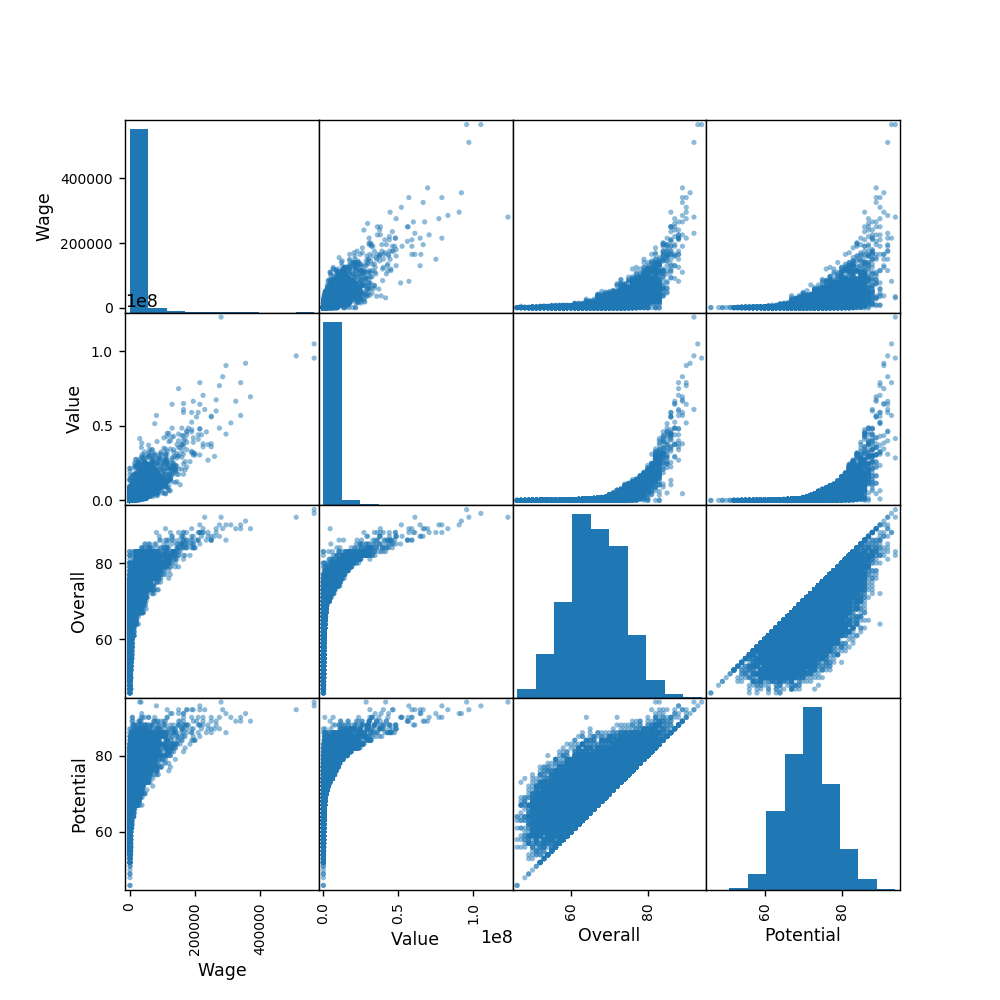

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019BEA5F5860>,
      dtype=object)

In [48]:
attributes = ["Wage", "Value", "Overall", "Potential"]

scatter_matrix(df[attributes], figsize=(8,8))

<IPython.core.display.Javascript object>


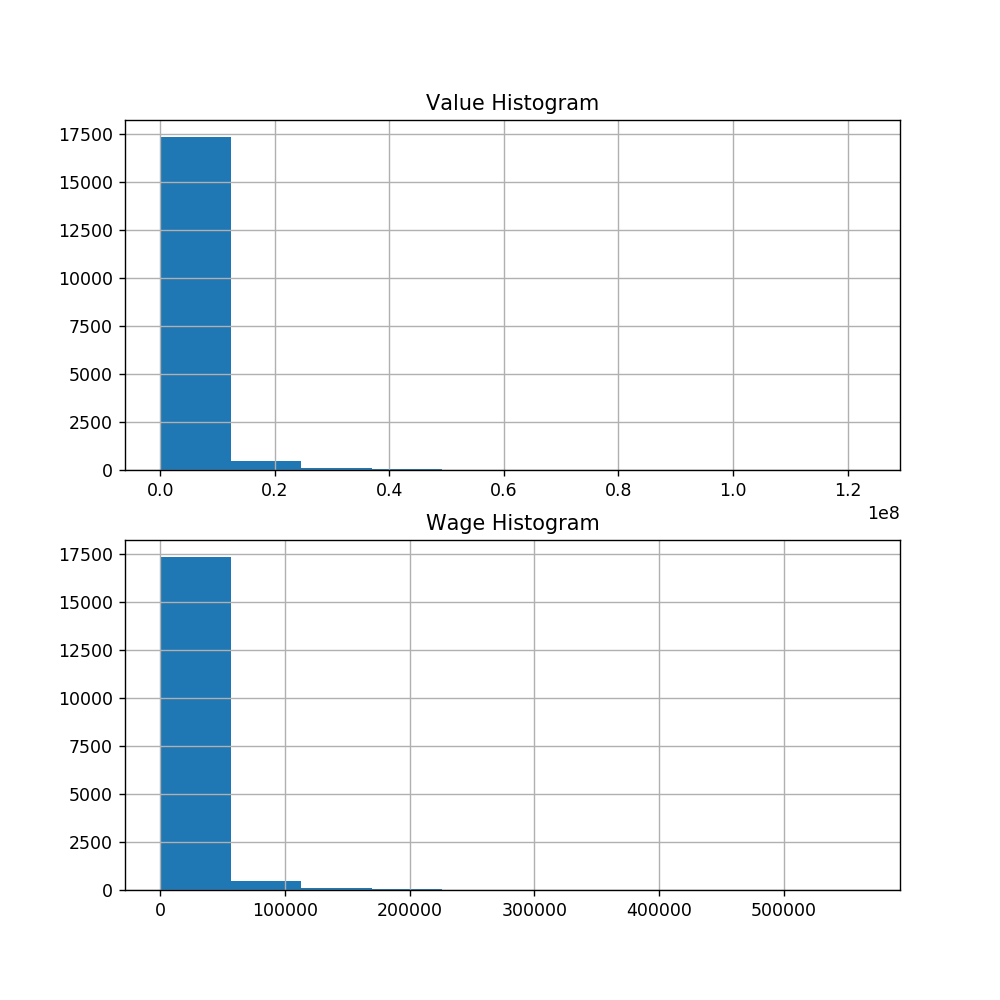

[]

In [49]:
# More detailed 'Value' and 'Wage' histograms

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

axes[0].title.set_text("Value Histogram")
axes[1].title.set_text("Wage Histogram")
df["Value"].hist(ax=axes[0])
df["Wage"].hist(ax=axes[1])

plt.plot()

### *Value* and *Wage* plots

<IPython.core.display.Javascript object>


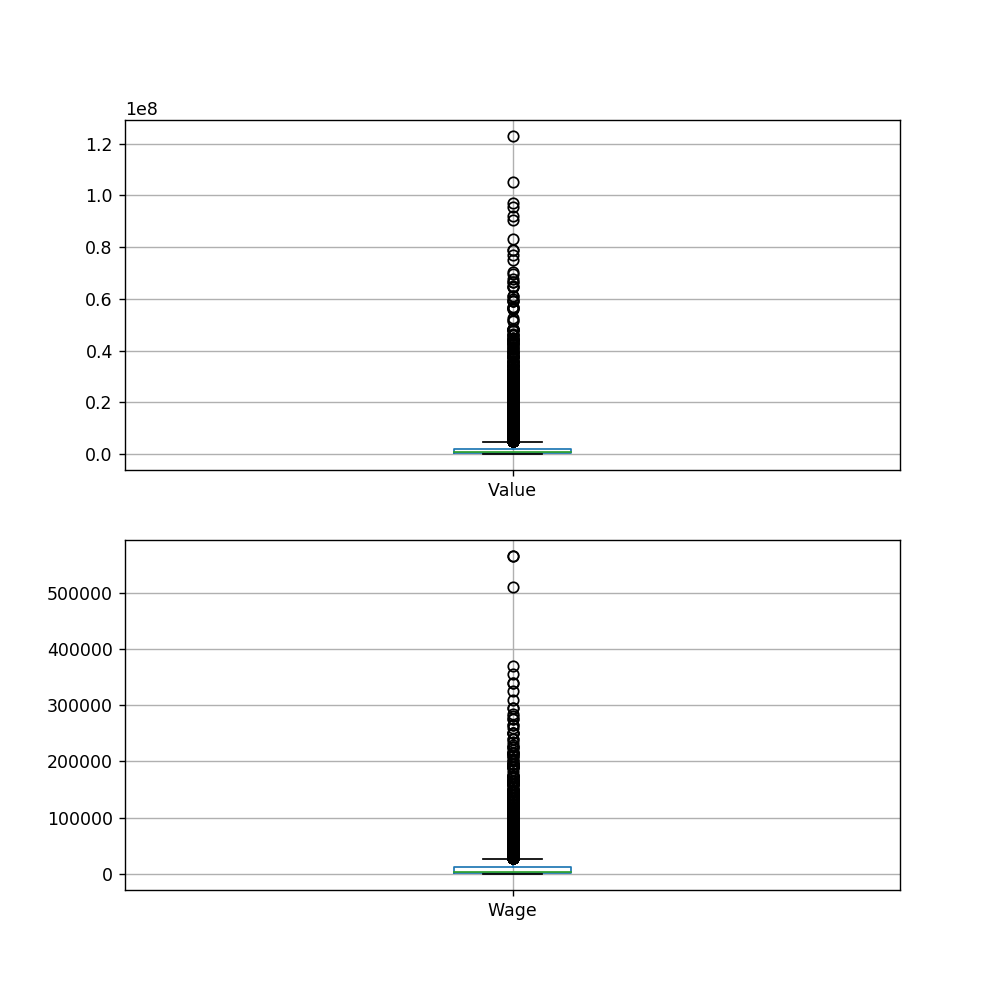

There are too many *outliers* in *Value* and *Wage*

In [50]:
# 'Value' and 'Wage' boxplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

display(md("There are too many *outliers* in *Value* and *Wage*"))
df.boxplot(column=["Value"], ax=axes[0])
df.boxplot(column=["Wage"], ax=axes[1])

### Feature Scaling
Machine Learning algorithms don't perform well when the input numerical attributes have very differnt scales.

In [51]:
columns_to_scale = [c for c in df.columns.values if c not in ["Name", "Value"]]

scaler = MinMaxScaler()

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

c:\users\matias\miniconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Export the data
Exports the dataset cleaned

In [52]:
df.to_csv("data/processed/CompleteDataset_cleaned.csv", index=False, sep=";")